## CA 4 - Part 2, LLMs Spring 2025

- **Name:**
- **Student ID:**

---
#### Your submission should be named using the following format: `CA4_LASTNAME_STUDENTID.ipynb`.

---

TA Email: miladmohammadi@ut.ac.ir

##### *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says ```Your Answer Here``` with your actual answer.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

## Text2SQL

In this section, you will progressively build and evaluate multiple Text-to-SQL pipelines. You’ll start with a simple prompting-based baseline, then design a graph-based routing system using chain-of-thought and schema reasoning, and finally construct a ReAct agent that interacts with the schema via tools. Each stage demonstrates a different strategy for generating SQL from natural language using LLMs.

### Initializations

This section prepares the environment and initializes the LLM model (Gemini) to be used in later parts of the notebook.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
import os
import re

from typing import Literal, Optional #
from pydantic import BaseModel, Field #

from langchain_google_genai import ChatGoogleGenerativeAI # برای llm
from langchain_core.messages import SystemMessage, HumanMessage #
from langchain_core.prompts import ChatPromptTemplate #
from langchain_core.runnables import Runnable #

from langgraph.graph import MessagesState, StateGraph, START

#### Load API Key (2 Points)

**Task:** Load the Gemini API key stored in the `.env` file and set it as an environment variable so it can be used to authenticate API requests later.

* Use `dotenv` to load the file.
* Extract the API key with `os.getenv`.

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
  raise ValueError("GOOGLE_API_KEY not found in .env file or environment variable")

#### Create ChatModel (3 Points)

**Task:** Create an instance of the Gemini LLM using LangChain. You should configure the model with proper parameters for our task.

Note: You may use any model that supports Structured Output and Tool Use. We recommend using gemini-2.5-flash-preview-05-20 from Google AI Studio, as it offers a generous free tier.

In [19]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_param = {
    "model": "gemini-2.5-flash-preview-05-20",
    "temperature": 0.01,
    "max_output_tokens": 512,

}
# Create an instance of the Gemini LLM
llm = ChatGoogleGenerativeAI(model_kwargs=gemini_param, google_api_key=GOOGLE_API_KEY)

C:\Users\sazgar\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3553: UserWarning: Parameters {'max_output_tokens', 'temperature', 'model'} should be specified explicitly. Instead they were passed in as part of `model_kwargs` parameter.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
response = llm.invoke("just say Meow!")
print(response.content)

Meow!


### Baseline

In this section, you'll build a simple baseline pipeline that directly converts a question and schema into a SQL query using a single prompt.

#### Baseline Function (5 Points)


**Task:** Implement a function that sends a system message defining the task, and a user message containing the input question and schema. The LLM should return the SQL query formatted as: "```sql\n[query]```"

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage

def run_baseline(question: str, schema: str):
    sys_msg = """
    ### TASK DESCRIPTION
    You are an expert systems that receives a user's question and a database schema. \
    Generate a SQL query that answers the question.

    ### FORMAT
    formatted as a markdown SQL code block:\n
    ```sql
    [query]
    ```
    """
    user_msg = f"""
    Question: {question}\n
    Schema:\n{schema}\n
    Only generate the SQL query, nothing else.
    """

    messages = [
        SystemMessage(content=sys_msg),
        HumanMessage(content=user_msg)
    ]

    response = llm.invoke(messages)
    sql_query = response.content

    return sql_query

#### Run and Evaluate (Estimated Run Time 5-10min)

Run your baseline function over the dataset provided.

In [5]:
from method_run import run_method
import re

def function_template(item):
    result = run_baseline(item['question'], item['schema'])
    # First try to extract query from markdown SQL block
    match = re.search(r'```sql\n(.*?)```', result, re.DOTALL)
    if match:
        query = match.group(1).strip()
    else:
        # If no markdown block found, try to extract just SQL query
        query = result.strip()
        # Remove any ```sql or ``` if present without proper formatting
        query = re.sub(r'```sql|```', '', query).strip()

    print(f"Question: {item['question']}")
    print(f"Schema: {item['schema']}")
    print(f"Generated SQL: {query}\n")

    return {**item, 'sql': query}

run_method(function_template, SLEEP_TIME=10)

#Run on mode=nano if you want to test it on a smaller dataset
#run_method(function_template, SLEEP_TIME=10, mode="nano")

  0%|          | 0/18 [00:00<?, ?it/s]

Question: Find the percentage of atoms with single bond. (Evidence: single bond refers to bond_type = '-'; percentage = DIVIDE(SUM(bond_type = '-'), COUNT(bond_id)) as percentage)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: SELECT
  CAST(SUM(CASE WHEN bond_type = '-' THEN 1 ELSE 0 END) AS REAL) * 100 / COUNT(bond_id)
FROM bond;



  6%|▌         | 1/18 [00:11<03:09, 11.15s/it]

Question: Indicate which atoms are connected in non-carcinogenic type molecules. (Evidence: label = '-' means molecules are non-carcinogenic)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: SELECT
  T1.atom_id,
  T1.atom_id2
FROM connected AS T1
INNER JOIN bond AS T2
  ON T1.bond_id = T2.bond_id
INNER JOIN molecule AS T3
  ON T2.molecule_id = T3.molecule_id
WHERE
  T3.label = '-';



 11%|█         | 2/18 [00:23<03:06, 11.64s/it]

Question: What is the average number of bonds the atoms with the element iodine have? (Evidence: atoms with the element iodine refers to element = 'i'; average = DIVIDE(COUND(bond_id), COUNT(atom_id)) where element = 'i')
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: 



 17%|█▋        | 3/18 [00:36<03:03, 12.26s/it]

Question: List down two molecule id of triple bond non carcinogenic molecules with element carbon. (Evidence: carbon refers to element = 'c'; triple bond refers to bond_type = '#'; label = '-' means molecules are non-carcinogenic)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: SELECT DISTINCT
  T1.molecule_id
FROM molecule AS T1
INNER JOIN bond AS T2
  ON T1.molecule_id = T2.molecule_id
INNER JOIN atom AS T3
  ON T1.molecule_id = T3.molecule_id
WHERE
  T2.bond_type = '#' AND T3.element = 'c' AND T1.label = '-'
LIMIT 2;



 22%|██▏       | 4/18 [00:47<02:49, 12.09s/it]

Question: What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: SELECT T1.element, T2.label
FROM atom AS T1
INNER JOIN molecule AS T2
  ON T1.molecule_id = T2.molecule_id
WHERE
  T1.molecule_id = 'TR060';



 28%|██▊       | 5/18 [00:58<02:32, 11.70s/it]

Question: What are the elements for bond id TR001_10_11? (Evidence: element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Generated SQL: SELECT DISTINCT T3.element
FROM bond AS T1
INNER JOIN connected AS T2
  ON T1.bond_id = T2.bond_id
INNER JOIN atom AS T3
  ON T2.atom_id = T3.atom_id OR T2.atom_id2 = T3.atom_id
WHERE
  T1.bond_id = 'TR001_10_11';



 33%|███▎      | 6/18 [01:12<02:27, 12.28s/it]

Question: How many superheroes were published by Dark Horse Comics? (Evidence: published by Dark Horse Comics refers to publisher_name = 'Dark Horse Comics';)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Generated SQL: SELECT
  COUNT(s.id)
FROM superhero AS s
JOIN publisher AS p
  ON s.publisher_id = p.id
WHERE
  p.publisher_name = 'Dark Horse Comics';



 39%|███▉      | 7/18 [01:23<02:10, 11.90s/it]

Question: What are the race and alignment of Cameron Hicks? (Evidence: Cameron Hicks refers to superhero_name = 'Cameron Hicks';)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Generated SQL: SELECT
  T2.race,
  T3.alignment
FROM superhero AS T1
INNER JOIN race AS T2
ON T1.race_id = T2.id
INNER JOIN alignment AS T3
ON T1.alignment_id = T3.id
WHERE
  T1.superhero_name = 'Cameron Hicks';



 44%|████▍     | 8/18 [01:35<01:58, 11.90s/it]

Question: Among the superheroes with height from 170 to 190, list the names of the superheroes with no eye color. (Evidence: height from 170 to 190 refers to height_cm BETWEEN 170 AND 190; no eye color refers to eye_colour_id = 1)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Generated SQL: SELECT superhero_name
FROM superhero
WHERE height_cm BETWEEN 170 AND 190 AND eye_colour_id = 1;



 50%|█████     | 9/18 [01:46<01:45, 11.70s/it]

Question: List down at least five superpowers of male superheroes. (Evidence: male refers to gender = 'Male'; superpowers refers to power_name;)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Generated SQL: SELECT DISTINCT
  sp.power_name
FROM superpower AS sp
JOIN hero_power AS hp
  ON sp.id = hp.power_id
JOIN superhero AS sh
  ON hp.hero_id = sh.id
JOIN gender AS g
  ON sh.gender_id = g.id
WHERE
  g.gender = 'Male'
LIMIT 5;



 56%|█████▌    | 10/18 [01:58<01:32, 11.61s/it]

Question: What is the percentage of superheroes who act in their own self-interest or make decisions based on their own moral code? Indicate how many of the said superheroes were published by Marvel Comics. (Evidence: published by Marvel Comics refers to publisher_name = 'Marvel Comics'; superheroes who act in their own self-interest or make decisions based on their own moral code refers to alignment = 'Bad'; calculation = MULTIPLY(DIVIDE(SUM(alignment = 'Bad); count(id)), 100))
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
hero_power (hero_id, power_id)

Generated SQL: SELECT
  (
    COUNT(CASE WHEN T2.alignment = 'Bad' THEN T1.id END) * 100.

 61%|██████    | 11/18 [02:11<01:25, 12.17s/it]

Question: Which publisher created more superheroes: DC or Marvel Comics? Find the difference in the number of superheroes. (Evidence: DC refers to publisher_name = 'DC Comics'; Marvel Comics refers to publisher_name = 'Marvel Comics'; if SUM(publisher_name = 'DC Comics') > SUM(publisher_name = 'Marvel Comics'), it means DC Comics published more superheroes than Marvel Comics; if SUM(publisher_name = 'Marvel Comics') > SUM(publisher_name = 'Marvel Comics'), it means Marvel Comics published more heroes than DC Comics; difference = SUBTRACT(SUM(publisher_name = 'DC Comics'), SUM(publisher_name = 'Marvel Comics'));)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (i

 67%|██████▋   | 12/18 [02:24<01:14, 12.44s/it]

Question: Who was the first one paid his/her dues? Tell the full name. (Evidence: full name refers to first_name, last_name; first paid dues refers to MIN(received_date) where source = 'Dues')
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: SELECT
  T1.first_name,
  T1.last_name
FROM member AS T1
INNER JOIN income AS T2
  ON T1.member_id = T2.link_to_member
WHERE
  T2.source = 'Dues' AND T2.date_received = (
    SELECT
      MIN(date_

 72%|███████▏  | 13/18 [02:37<01:02, 12.52s/it]

Question: How many income are received with an amount of 50? (Evidence: amount of 50 refers to amount = 50)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: SELECT
  COUNT(income_id)
FROM income
WHERE
  amount = 50;



 78%|███████▊  | 14/18 [02:48<00:48, 12.05s/it]

Question: Name the event with the highest amount spent on advertisement. (Evidence: event refers to event_name; highest amount spent on advertisement refers to MAX(spent) where category = 'Advertisement')
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: SELECT
  T1.event_name
FROM event AS T1
INNER JOIN budget AS T2
  ON T1.event_id = T2.link_to_event
WHERE
  T2.category = 'Advertisement'
ORDER BY
  T2.spent DESC
LIMIT 1;



 83%|████████▎ | 15/18 [02:59<00:35, 11.87s/it]

Question: Based on the total cost for all event, what is the percentage of cost for Yearly Kickoff event? (Evidence: DIVIDE(SUM(cost where event_name = 'Yearly Kickoff'), SUM(cost)) * 100)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: SELECT
  SUM(CASE WHEN T3.event_name = 'Yearly Kickoff' THEN T1.cost ELSE 0 END) * 100.0 / SUM(T1.cost)
FROM expense AS T1
INNER JOIN budget AS T2
  ON T1.link_to_budget = T2.budget_id
INNER JOIN event

 89%|████████▉ | 16/18 [03:11<00:23, 11.97s/it]

Question: Calculate the total average cost that Elijah Allen spent in the events on September and October. (Evidence: events in September and October refers to month(expense_date) = 9 AND MONTH(expense_date) = 10)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: SELECT
  AVG(T1.cost)
FROM expense AS T1
INNER JOIN member AS T2
  ON T1.link_to_member = T2.member_id
WHERE
  T2.first_name = 'Elijah' AND T2.last_name = 'Allen' AND (
    STR

 94%|█████████▍| 17/18 [03:23<00:11, 11.85s/it]

Question: Find the name and date of events with expenses for pizza that were more than fifty dollars but less than a hundred dollars. (Evidence: name of event refers to event_name; date of event refers to event_date; expenses for pizza refers to expense_description = 'Pizza' where cost > 50 and cost < 100)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

Generated SQL: SELECT
  T1.event_name,
  T1.event_date
FROM event AS T1
INNER JOIN budget AS T2
 

100%|██████████| 18/18 [03:35<00:00, 11.95s/it]


Starting to compare without knowledge for ex
Process finished successfully
start calculate
                     simple               moderate             challenging          total               
count                6                    6                    6                    18                  
======================================    ACCURACY    =====================================
accuracy             66.67                83.33                83.33                77.78               
Finished evaluation



### Chain/Router

Here, you will build a more advanced system that routes the query through different paths based on question difficulty. Easier questions go straight to query generation; harder ones go through schema path extraction first.

#### Define State (5 Points)

**Task:** Define a `RouterGraphState` using `MessagesState` and `pydantic` that contains:
* The input question and schema
* The predicted difficulty level
* The extracted schema path
* The final query

In [4]:
from typing import List, Literal, Optional
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

class RouterGraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: The user's question.
        schema: The database schema.
        messages: The list of messages exchanged in the graph.
        question_difficulty: The classified difficulty of the question.
        reasoning: The reasoning behind the difficulty classification. # <-- اضافه شد
        key_factors: Key factors influencing the difficulty. # <-- اضافه شد
        schema_path: The relevant schema subset for complex questions.
        query: The final generated SQL query.
    """
    question: str
    schema: str
    messages: List[BaseMessage]
    
    question_difficulty: Optional[Literal["simple", "moderate", "challenging"]]
    reasoning: Optional[str]        
    key_factors: Optional[List[str]]

    schema_path: Optional[str]
    query: Optional[str]

#### Node: Analyser (5 Points)

**Task:** Build a node that:
* Accepts a question and schema
* Analyzes the difficulty (simple/moderate/challanging)
* Uses the LLM’s structured output feature to return the difficulty

**Steps**:

1. Define a Pydantic class to hold the expected structured output.
2. Use structure output mode of LLM to bind it to the model.

In [34]:
from pydantic import BaseModel, Field

class QuestionDifficultyAnalysis(BaseModel):
    question_difficulty: Literal["simple", "moderate", "challenging"] = Field(
        ..., description="The difficulty level of the question."
    )
    reasoning: str = Field(
        ..., description="Brief explanation for why this difficulty was assigned."
    )
    key_factors: list[str] = Field(
        ..., description="List of key factors that influenced the difficulty assessment."
    )

def analyser_node(state: RouterGraphState) -> dict:
    """
    Analyzes the user's question, handles potential failures,
    and updates the state with the full analysis.
    """
    print("---(1) ANALYZING QUESTION---")
    
    prompt = f"""
    Analyze the difficulty of this SQL question based on the database schema provided.

    Question: {state['question']}
    Schema: {state['schema']}

    Consider these factors:
    - Simple: Single table queries, basic WHERE conditions.
    - Moderate: Joins between 2-3 tables, basic aggregations.
    - Challenging: Complex joins, nested queries, advanced aggregations.

    Provide your analysis with reasoning and key factors.
    """
    
    try:
        structured_llm = llm.with_structured_output(QuestionDifficultyAnalysis)
        response = structured_llm.invoke(prompt)
        
        if response is None:
            raise ValueError("LLM returned a None response without raising an exception.")

        print("✅ Analysis successful.")
        return {
            "question_difficulty": response.question_difficulty,
            "reasoning": response.reasoning,
            "key_factors": response.key_factors
        }
    except Exception as e:
        print(f"❌ ERROR during analysis: {e}. Defaulting to 'moderate'.")
        return {
            "question_difficulty": "moderate",
            "reasoning": f"LLM analysis failed: {e}. Defaulting.",
            "key_factors": ["LLM_FAILURE"]
        }

#### Conditional Edge (2 Points)

**Task:** Implement a branching function that decides whether to proceed to direct query generation or schema path extraction based on the difficulty label returned by the analyser.

* If the difficulty is “easy”, go directly to query generation.
* Otherwise, extract the schema path first.

In [29]:
from typing import Literal

def is_schema_extraction_needed(state: RouterGraphState) -> Literal["schema_path_extractor", "query_generator"]:
    """
    This defensively-coded routing function determines the next step.
    It handles missing keys, incorrect types, and empty strings to prevent crashes.
    """
    print("---(2) ROUTING DECISION---")
    
    difficulty = state.get('question_difficulty')

    if difficulty is None:
        print("⚠️ Difficulty is None. Defaulting to the safer path (schema extraction).")
        return "schema_path_extractor"

    if not isinstance(difficulty, str):
        print(f"⚠️ ERROR: Expected difficulty to be a string, but got {type(difficulty)}. Defaulting to safer path.")
        return "schema_path_extractor"

    difficulty_normalized = difficulty.strip().lower()
    
    if not difficulty_normalized:
        print("⚠️ Difficulty is an empty string. Defaulting to safer path.")
        return "schema_path_extractor"

    print(f"Difficulty is '{difficulty_normalized}'. Deciding next step...")

    if difficulty_normalized == "simple":
        print("✅ Routing to: query_generator")
        return "query_generator"
    else:
        print("✅ Routing to: schema_path_extractor")
        return "schema_path_extractor"

#### Node: Schema Extractor (3 Points)

**Task:** Implement a node that takes the question and schema and extracts a join path or sequence of relevant tables from the schema based on the question.

* Use a simple prompt for this.
* Store the result in the `schema_path` field of the state.

In [30]:
from langchain_core.prompts import ChatPromptTemplate

SCHEMA_FILTER_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", """
You are a hyper-efficient database schema filter. Your SOLE task is to extract the exact, complete `CREATE TABLE` statements for ONLY the tables needed to answer the user's question from the provided full schema.

### RULES:
1.  **Analyze the Question:** Identify all entities and relationships mentioned or implied in the user's question.
2.  **Identify Core & Related Tables:** Find the primary tables containing the requested information and any other tables required for JOIN operations to connect the data.
3.  **Extract Exact Schema:** For every table you identify as relevant, copy its full, original `CREATE TABLE ...;` statement.
4.  **Output MUST be Clean:**
    - Your entire output must ONLY be the sequence of `CREATE TABLE` statements.
    - DO NOT include any explanations, reasoning, introductions, or titles.
    - DO NOT wrap the output in markdown blocks like ```sql.

### Example:
If the relevant tables are 'employees' and 'departments', your output should be:
CREATE TABLE employees (...);

CREATE TABLE departments (...);
"""),
        ("human", """
Full Database Schema:
{schema}

User Question:
{question}
""")
    ]
)

schema_filter_chain = SCHEMA_FILTER_PROMPT | llm

def schema_path_extractor_node(state: RouterGraphState) -> dict:
    """
    Acts as a schema filter. It extracts only the relevant CREATE TABLE statements
    from the full schema based on the user's question.
    """
    print("---(3) FILTERING SCHEMA (Context Reduction)---")
    
    inputs = {
        "question": state["question"],
        "schema": state['schema']
    }
    
    try:
        response = schema_filter_chain.invoke(inputs)
        extracted_schema_subset = response.content.strip()

        if not extracted_schema_subset:
            raise ValueError("LLM returned an empty schema subset.")

        print(f"✅ Schema subset extracted successfully.")
        return {"schema_path": extracted_schema_subset}

    except Exception as e:
        print(f"⚠️ Schema filtering failed: {e}. Using full schema as fallback.")
        return {"schema_path": state['schema']}

#### Node: Generator (5 Points)

**Task:** Generate the SQL query based on the question and schema.

* If a schema path is available, include it in the prompt.
* Save the output query in the `query` field of the state.


In [31]:
from langchain_core.prompts import ChatPromptTemplate
import re

QUERY_GENERATOR_PROMPT = ChatPromptTemplate.from_messages(
    [
        ("system", """
You are a master SQL generator. Your ONLY task is to write a single, precise, and correct SQL query to answer the user's question based on the provided schema.

### RULES:
-   Use ONLY the tables and columns present in the provided schema. Do not invent or hallucinate any elements.
-   Your entire response MUST be only the SQL query inside a markdown block.
-   Do not include any explanations, comments, or any text outside the markdown block.

Output format:
```sql
[YOUR_SQL_QUERY_HERE]
"""),
("human", """
Database Schema:
{schema}

User Question:
{question}
""")
]
)
query_generator_chain = QUERY_GENERATOR_PROMPT | llm

def query_generator_node(state: RouterGraphState) -> dict:
    """
    Generates the final SQL query. It uses the filtered schema_path if available,
    otherwise it falls back to the full schema. It then sanitizes the output.
    """
    print("---(4) GENERATING FINAL SQL QUERY---")
    
    effective_schema = state.get("schema_path") or state["schema"]
    
    print(f"Using schema for generation (length: {len(effective_schema)} chars)")
    
    inputs = {
        "question": state["question"],
        "schema": effective_schema
    }
    
    result = query_generator_chain.invoke(inputs)
    raw_output = result.content.strip()
    
    sql_match = re.search(r"```sql\s*(.*?)\s*```", raw_output, re.DOTALL | re.IGNORECASE)
    
    if sql_match:
        sql_query = sql_match.group(1).strip()
    else:
        sql_query = raw_output
        print("⚠️ Could not find a ```sql block. Using raw output as query.")

    print(f"✅ Final SQL Query Generated:\n---\n{sql_query}\n---")
    return {"query": sql_query}

#### Build Graph (5 Points)

**Task:** Assemble the full routing graph using the nodes and edges you created.

In [35]:
from langgraph.graph import StateGraph

print("---(5) BUILDING THE FINAL GRAPH---")

router_graph_builder = StateGraph(RouterGraphState)

router_graph_builder.add_node("analyser", analyser_node)
router_graph_builder.add_node("schema_path_extractor", schema_path_extractor_node)
router_graph_builder.add_node("query_generator", query_generator_node)

router_graph_builder.set_entry_point("analyser")

router_graph_builder.add_conditional_edges(
    "analyser",
    is_schema_extraction_needed,
    {
        "schema_path_extractor": "schema_path_extractor",
        "query_generator": "query_generator",
    }
)

router_graph_builder.add_edge("schema_path_extractor", "query_generator")

router_graph_builder.set_finish_point("query_generator")


router_graph = router_graph_builder.compile()

print("✅ Graph compiled successfully! It's ready to run.")

---(5) BUILDING THE FINAL GRAPH---
✅ Graph compiled successfully! It's ready to run.


#### Run and Evaluate (Estimated Run Time 10-15min)

**Task:** Run your compiled routing graph on a dataset. For each question:

* Instantiate the `RouterGraphState` with the question and schema.
* Run the graph to completion.
* Extract and clean the query from the result.

Use the `run_method` function to handle iteration and timing.

In [64]:
from method_run import run_method
def run_router_graph(item):
    response = router_graph.invoke(
        RouterGraphState(
            question=item['question'],
            schema=item['schema'],
            schema_path=None,
            question_difficulty=None,
            query=None
        )
    )
    result = response["query"]
    # First try to extract query from markdown SQL block
    match = re.search(r'```sql\n(.*?)```', result, re.DOTALL)
    if match:
        query = match.group(1).strip()
    else:
        # If no markdown block found, try to extract just SQL query
        query = result.strip()
        # Remove any ```sql or ``` if present without proper formatting
        query = re.sub(r'```sql|```', '', query).strip()
    print(f"Question: {item['question']}")
    print(f"Schema: {item['schema']}")
    print(f"Question Difficulty: {response['question_difficulty']}")
    if response["schema_path"]:
        print(f"Schema Path: {response['schema_path']}")
    print(f"Generated SQL: {query}\n")
    return {**item, 'sql': query}


run_method(run_router_graph, SLEEP_TIME=30)

#Run on mode=nano if you want to test it on a smaller dataset
# run_method(run_router_graph, SLEEP_TIME=15, mode="nano")

  0%|          | 0/18 [00:00<?, ?it/s]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 52 chars)
✅ Final SQL Query Generated:
---
SELECT
  CAST(SUM(CASE WHEN bond_type = '-' THEN 1 ELSE 0 END) AS REAL) * 100.0 / COUNT(bond_id)
FROM bond;
---
Question: Find the percentage of atoms with single bond. (Evidence: single bond refers to bond_type = '-'; percentage = DIVIDE(SUM(bond_type = '-'), COUNT(bond_id)) as percentage)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Question Difficulty: moderate
Schema Path: CREATE TABLE bond (bond_id, molecule_id, bond_type);
Gen

  6%|▌         | 1/18 [00:38<10:51, 38.30s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 149 chars)
✅ Final SQL Query Generated:
---
SELECT
  T1.atom_id,
  T1.atom_id2
FROM connected AS T1
INNER JOIN bond AS T2
  ON T1.bond_id = T2.bond_id
INNER JOIN molecule AS T3
  ON T2.molecule_id = T3.molecule_id
WHERE
  T3.label = '-';
---
Question: Indicate which atoms are connected in non-carcinogenic type molecules. (Evidence: label = '-' means molecules are non-carcinogenic)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Question Difficulty: moderate
Schema Path: CREATE 

 11%|█         | 2/18 [01:19<10:36, 39.79s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 158 chars)
⚠️ Could not find a ```sql block. Using raw output as query.
✅ Final SQL Query Generated:
---

---
Question: What is the average number of bonds the atoms with the element iodine have? (Evidence: atoms with the element iodine refers to element = 'i'; average = DIVIDE(COUND(bond_id), COUNT(atom_id)) where element = 'i')
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

Question Difficulty: moderate
Schema Path: CREATE TABLE atom (atom_id, molecule_id, element);

CREATE 

 17%|█▋        | 3/18 [01:56<09:43, 38.89s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 147 chars)
✅ Final SQL Query Generated:
---
SELECT T1.molecule_id
FROM molecule AS T1
INNER JOIN atom AS T2
  ON T1.molecule_id = T2.molecule_id
INNER JOIN bond AS T3
  ON T1.molecule_id = T3.molecule_id
WHERE
  T2.element = 'c' AND T3.bond_type = '#' AND T1.label = '-'
LIMIT 2;
---
Question: List down two molecule id of triple bond non carcinogenic molecules with element carbon. (Evidence: carbon refers to element = 'c'; triple bond refers to bond_type = '#'; label = '-' means molecules are non-carcinogenic)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, 

 22%|██▏       | 4/18 [02:33<08:52, 38.06s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 94 chars)
✅ Final SQL Query Generated:
---
SELECT T1.element, T2.label FROM atom AS T1 JOIN molecule AS T2 ON T1.molecule_id = T2.molecule_id WHERE T1.molecule_id = 'TR060';
---
Question: What are the elements of the toxicology and label of molecule TR060? (Evidence: TR060 is the molecule id; label = '+' mean molecules are carcinogenic; label = '-' means molecules are non-carcinogenic; element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phos

 28%|██▊       | 5/18 [03:09<08:04, 37.26s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 158 chars)
✅ Final SQL Query Generated:
---
SELECT DISTINCT T3.element
FROM bond AS T1
INNER JOIN connected AS T2
  ON T1.bond_id = T2.bond_id
INNER JOIN atom AS T3
  ON T2.atom_id = T3.atom_id
WHERE
  T1.bond_id = 'TR001_10_11'
UNION
SELECT DISTINCT T3.element
FROM bond AS T1
INNER JOIN connected AS T2
  ON T1.bond_id = T2.bond_id
INNER JOIN atom AS T3
  ON T2.atom_id2 = T3.atom_id
WHERE
  T1.bond_id = 'TR001_10_11';
---
Question: What are the elements for bond id TR001_10_11? (Evidence: element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; eleme

 33%|███▎      | 6/18 [03:46<07:26, 37.17s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 368 chars)
✅ Final SQL Query Generated:
---
SELECT
  COUNT(T1.id)
FROM superhero AS T1
INNER JOIN publisher AS T2
  ON T1.publisher_id = T2.id
WHERE
  T2.publisher_name = 'Dark Horse Comics';
---
Question: How many superheroes were published by Dark Horse Comics? (Evidence: published by Dark Horse Comics refers to publisher_name = 'Dark Horse Comics';)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_i

 39%|███▉      | 7/18 [04:23<06:46, 36.98s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 390 chars)
✅ Final SQL Query Generated:
---
SELECT T2.race, T3.alignment FROM superhero AS T1 INNER JOIN race AS T2 ON T1.race_id = T2.id INNER JOIN alignment AS T3 ON T1.alignment_id = T3.id WHERE T1.superhero_name = 'Cameron Hicks';
---
Question: What are the race and alignment of Cameron Hicks? (Evidence: Cameron Hicks refers to superhero_name = 'Cameron Hicks';)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id,

 44%|████▍     | 8/18 [05:00<06:09, 36.94s/it]

---(1) ANALYZING QUESTION---
✅ Analysis successful.
---(2) ROUTING DECISION---
Difficulty is 'simple'. Deciding next step...
✅ Routing to: query_generator
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 418 chars)
✅ Final SQL Query Generated:
---
SELECT superhero_name
FROM superhero
WHERE height_cm BETWEEN 170 AND 190 AND eye_colour_id = 1;
---
Question: Among the superheroes with height from 170 to 190, list the names of the superheroes with no eye color. (Evidence: height from 170 to 190 refers to height_cm BETWEEN 170 AND 190; no eye color refers to eye_colour_id = 1)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm, weight_kg)
hero_attribute (hero_id, attribute_id, attribute_value)
superpower (id, power_name)
h

 50%|█████     | 9/18 [05:33<05:21, 35.77s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 460 chars)
✅ Final SQL Query Generated:
---
SELECT DISTINCT
  T3.power_name
FROM gender AS T1
INNER JOIN superhero AS T2
  ON T1.id = T2.gender_id
INNER JOIN hero_power AS T4
  ON T2.id = T4.hero_id
INNER JOIN superpower AS T3
  ON T4.power_id = T3.id
WHERE
  T1.gender = 'Male'
LIMIT 5;
---
Question: List down at least five superpowers of male superheroes. (Evidence: male refers to gender = 'Male'; superpowers refers to power_name;)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)

 56%|█████▌    | 10/18 [06:10<04:48, 36.10s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 405 chars)
⚠️ Could not find a ```sql block. Using raw output as query.
✅ Final SQL Query Generated:
---

---
Question: What is the percentage of superheroes who act in their own self-interest or make decisions based on their own moral code? Indicate how many of the said superheroes were published by Marvel Comics. (Evidence: published by Marvel Comics refers to publisher_name = 'Marvel Comics'; superheroes who act in their own self-interest or make decisions based on their own moral code refers to alignment = 'Bad'; calculation = MULTIPLY(DIVIDE(SUM(alignment = 'Bad); count(id)), 

 61%|██████    | 11/18 [06:47<04:16, 36.59s/it]

---(1) ANALYZING QUESTION---
✅ Analysis successful.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 719 chars)
⚠️ Could not find a ```sql block. Using raw output as query.
✅ Final SQL Query Generated:
---

---
Question: Which publisher created more superheroes: DC or Marvel Comics? Find the difference in the number of superheroes. (Evidence: DC refers to publisher_name = 'DC Comics'; Marvel Comics refers to publisher_name = 'Marvel Comics'; if SUM(publisher_name = 'DC Comics') > SUM(publisher_name = 'Marvel Comics'), it means DC Comics published more superheroes than Marvel Comics; if SUM(publisher_name = 'Marvel Comics') > SUM(publisher_name = 'Marvel Comics'), it means Marvel Comics published more heroes than DC Comics; difference = SUBTRACT(SUM(publisher_name = '

 67%|██████▋   | 12/18 [07:25<03:42, 37.04s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 312 chars)
✅ Final SQL Query Generated:
---
SELECT
  T2.first_name,
  T2.last_name
FROM income AS T1
INNER JOIN member AS T2
  ON T1.link_to_member = T2.member_id
WHERE
  T1.source = 'Dues'
ORDER BY
  T1.date_received
LIMIT 1;
---
Question: Who was the first one paid his/her dues? Tell the full name. (Evidence: full name refers to first_name, last_name; first paid dues refers to MIN(received_date) where source = 'Dues')
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, co

 72%|███████▏  | 13/18 [08:02<03:04, 36.88s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 86 chars)
✅ Final SQL Query Generated:
---
SELECT count(*) FROM income WHERE amount = 50;
---
Question: How many income are received with an amount of 50? (Evidence: amount of 50 refers to amount = 50)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approve

 78%|███████▊  | 14/18 [08:37<02:25, 36.35s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 421 chars)
✅ Final SQL Query Generated:
---
SELECT T1.event_name
FROM event AS T1
INNER JOIN budget AS T2
  ON T1.event_id = T2.link_to_event
WHERE
  T2.category = 'Advertisement'
ORDER BY
  T2.spent DESC
LIMIT 1;
---
Question: Name the event with the highest amount spent on advertisement. (Evidence: event refers to event_name; highest amount spent on advertisement refers to MAX(spent) where category = 'Advertisement')
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, cou

 83%|████████▎ | 15/18 [09:13<01:49, 36.34s/it]

---(1) ANALYZING QUESTION---
✅ Analysis successful.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 303 chars)
✅ Final SQL Query Generated:
---
SELECT
  SUM(CASE WHEN T1.event_name = 'Yearly Kickoff' THEN T2.cost ELSE 0 END) * 100.0 / SUM(T2.cost)
FROM event AS T1
INNER JOIN expense AS T2
  ON T1.event_id = T2.link_to_event;
---
Question: Based on the total cost for all event, what is the percentage of cost for Yearly Kickoff event? (Evidence: DIVIDE(SUM(cost where event_name = 'Yearly Kickoff'), SUM(cost)) * 100)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, cate

 89%|████████▉ | 16/18 [09:49<01:12, 36.25s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 232 chars)
✅ Final SQL Query Generated:
---
SELECT
  AVG(T1.cost)
FROM expense AS T1
INNER JOIN member AS T2
  ON T1.link_to_member = T2.member_id
WHERE
  T2.first_name = 'Elijah' AND T2.last_name = 'Allen' AND (
    STRFTIME('%m', T1.expense_date) = '09' OR STRFTIME('%m', T1.expense_date) = '10'
  );
---
Question: Calculate the total average cost that Elijah Allen spent in the events on September and October. (Evidence: events in September and October refers to month(expense_date) = 9 AND MONTH(expense_date) = 10)
Schema: event (event_id, event_name, event_date, type, notes, locat

 94%|█████████▍| 17/18 [10:26<00:36, 36.24s/it]

---(1) ANALYZING QUESTION---
❌ ERROR during analysis: LLM returned a None response without raising an exception.. Defaulting to 'moderate'.
---(2) ROUTING DECISION---
Difficulty is 'moderate'. Deciding next step...
✅ Routing to: schema_path_extractor
---(3) FILTERING SCHEMA (Context Reduction)---
✅ Schema subset extracted successfully.
---(4) GENERATING FINAL SQL QUERY---
Using schema for generation (length: 303 chars)
✅ Final SQL Query Generated:
---
SELECT DISTINCT
  T1.event_name,
  T1.event_date
FROM event AS T1
INNER JOIN budget AS T2
  ON T1.event_id = T2.link_to_event
INNER JOIN expense AS T3
  ON T2.budget_id = T3.link_to_budget
WHERE
  T3.expense_description = 'Pizza' AND T3.cost > 50 AND T3.cost < 100;
---
Question: Find the name and date of events with expenses for pizza that were more than fifty dollars but less than a hundred dollars. (Evidence: name of event refers to event_name; date of event refers to event_date; expenses for pizza refers to expense_description = 'Pizza

100%|██████████| 18/18 [11:03<00:00, 36.84s/it]


Starting to compare without knowledge for ex
Process finished successfully
start calculate
                     simple               moderate             challenging          total               
count                6                    6                    6                    18                  
======================================    ACCURACY    =====================================
accuracy             66.67                66.67                83.33                72.22               
Finished evaluation



### Agent (ReAct)

Now you will implement a full ReAct agent that incrementally solves the Text-to-SQL task using tools. The agent can explore tables and columns before finalizing the query.

**You are not allowed to use 'Prebuilt Agent' of LangGraph. You have to build your own graph.**

#### Define Tools

**Task:** Define three tools for the agent to interact with the schema:
1. `get_samples_from_table`: Returns the first few rows of a table.
2. `get_column_description`: Provides a human-readable description of a specific column.
3. `execute`: Executes a SQL query.

In [21]:
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import ToolNode

from db_manager import DBManager
db_manager = DBManager()

@tool
def get_samples_from_table(table_name: str, config: RunnableConfig):
  """Gets the first few rows (samples) from a specified table.

  Args:
    table_name: The name of the table from which to fetch samples.

  Returns:
    The first few rows from the specified table.
  """
  db_name = config["configurable"].get("database_name")
  result = db_manager.get_table_head(table_name, db_name=db_name)
  return result

@tool
def get_column_description(table_name: str, column_name: str, config: RunnableConfig):
  """Provides a description for a specific column within a given table.

  Args:
    table_name: The name of the table containing the column.
    column_name: The name of the column for which to get the description.

  Returns:
    A string containing the description of the specified column.
  """
  db_name = config["configurable"].get("database_name")
  result = db_manager.get_column_description(db_name, table_name, column_name)
  return result

@tool
def execute(query: str, config: RunnableConfig):
  """Executes a given SQL query against the database.

  Args:
    query: The SQL query string to be executed.

  Returns:
    The result of the executed query. This could be a set of rows,
    a confirmation message, or an error.
  """
  db_name = config["configurable"].get("database_name")
  result = db_manager.query(query, db_name)
  return result

#### Extra Tool (5+5 Bonus Points):

**Task**: Create and integrate a new custom tool into the ReAct agent. To receive credit for this part, your tool must be meaningfully different from the existing three tools and provide practical value in helping the agent generate more accurate or efficient SQL queries.

In [62]:
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig

@tool
def get_table_schema(table_name: str, config: RunnableConfig):
    """
    Returns the full DDL (CREATE TABLE statement) for a specified table.

    Purpose
    -------
    • Gives the agent explicit knowledge of every column name, data type,
      primary key, and foreign-key relationship present in the table.
    • Enables accurate join construction and filter conditions without
      guessing column spellings or data types.
    • Complements the existing tools:
        – `get_samples_from_table`  → shows example rows (data-level view)  
        – `get_column_description`  → explains one column (semantic view)  
        – `execute`                 → validates a candidate query (runtime view)  
      `get_table_schema` supplies the **structural view**, which none of the
      earlier tools expose.

    Parameters
    ----------
    table_name : str
        Target table whose schema is requested.

    Returns
    -------
    str
        Exact `CREATE TABLE …` statement for the given table.
    """
    db_name = config["configurable"].get("database_name")

    if hasattr(db_manager, "get_table_schema"):
        return db_manager.get_table_schema(table_name, db_name=db_name)

    # Fallback for SQLite
    ddl_rows = db_manager.query(
        f"SELECT sql FROM sqlite_master WHERE type='table' AND name='{table_name}';",
        db_name=db_name
    )

    return ddl_rows[0]["sql"] if ddl_rows else f"-- Table `{table_name}` not found."

@tool
def get_related_tables(table_name: str, config: RunnableConfig):
    """
    Discovers all tables that are related to the specified table through
    foreign key relationships, both incoming and outgoing.

    Purpose
    -------
    • Identifies which tables can be JOINed with the target table
    • Shows the complete relationship graph around a table
    • Prevents missing important tables when answering complex questions
    • Helps understand the data model's connectivity patterns
    • Critical for multi-table queries where relationships aren't obvious

    This tool bridges the gap between knowing individual table schemas
    and understanding how tables connect across the entire database.

    Use Cases
    ---------
    • "Which tables connect to 'customers'?" → Shows orders, payments, etc.
    • "What can I join with 'products'?" → Shows categories, suppliers, order_items
    • "Find all tables related to 'employees'" → Shows departments, projects, timesheets

    Parameters
    ----------
    table_name : str
        Name of the table whose relationships to discover

    Returns
    -------
    str
        Formatted information about:
        - Tables that reference this table (incoming FKs)
        - Tables that this table references (outgoing FKs)  
        - The specific columns involved in each relationship
        - Relationship type (1:1, 1:many, many:1)
    """
    db_name = config["configurable"].get("database_name")
    
    try:
        relationships = []
        
        # Method 1: Use PRAGMA to find foreign keys FROM this table
        try:
            outgoing_fks = db_manager.query(
                f"PRAGMA foreign_key_list('{table_name}')", 
                db_name=db_name
            )
            
            for fk in outgoing_fks:
                relationships.append({
                    'type': 'OUTGOING',
                    'from_table': table_name,
                    'from_column': fk.get('from'),
                    'to_table': fk.get('table'),
                    'to_column': fk.get('to'),
                    'relationship': f"{table_name}.{fk.get('from')} → {fk.get('table')}.{fk.get('to')}"
                })
        except:
            pass
        
        # Method 2: Find all tables that reference THIS table (incoming FKs)
        try:
            # Get all table names first
            all_tables = db_manager.query(
                "SELECT name FROM sqlite_master WHERE type='table'", 
                db_name=db_name
            )
            
            for table_row in all_tables:
                other_table = table_row['name']
                if other_table == table_name:
                    continue
                    
                try:
                    fks_in_other_table = db_manager.query(
                        f"PRAGMA foreign_key_list('{other_table}')", 
                        db_name=db_name
                    )
                    
                    for fk in fks_in_other_table:
                        if fk.get('table') == table_name:
                            relationships.append({
                                'type': 'INCOMING',
                                'from_table': other_table,
                                'from_column': fk.get('from'),
                                'to_table': table_name,
                                'to_column': fk.get('to'),
                                'relationship': f"{other_table}.{fk.get('from')} → {table_name}.{fk.get('to')}"
                            })
                except:
                    continue
        except:
            pass
        
        # Format the output
        if not relationships:
            return f"🔍 No foreign key relationships found for table '{table_name}'\n" + \
                   f"💡 This table may be standalone or use implicit relationships"
        
        result = f"🔗 RELATIONSHIPS FOR TABLE: {table_name}\n\n"
        
        # Group by type
        outgoing = [r for r in relationships if r['type'] == 'OUTGOING']
        incoming = [r for r in relationships if r['type'] == 'INCOMING']
        
        if outgoing:
            result += "📤 OUTGOING REFERENCES (This table → Other tables):\n"
            for rel in outgoing:
                result += f"   • {rel['relationship']}\n"
            result += "\n"
        
        if incoming:
            result += "📥 INCOMING REFERENCES (Other tables → This table):\n"
            for rel in incoming:
                result += f"   • {rel['relationship']}\n"
            result += "\n"
        
        # Add JOIN suggestions
        all_related_tables = set()
        for rel in relationships:
            if rel['from_table'] != table_name:
                all_related_tables.add(rel['from_table'])
            if rel['to_table'] != table_name:
                all_related_tables.add(rel['to_table'])
        
        if all_related_tables:
            result += f"💡 JOINABLE TABLES: {', '.join(sorted(all_related_tables))}\n"
        
        return result
        
    except Exception as e:
        return f"❌ Error finding relationships for '{table_name}': {str(e)}"


#### Create Tool Node

In [63]:
tools = [get_related_tables, get_table_schema, get_samples_from_table, get_column_description, execute]

tools_node = ToolNode(tools=tools)

#### ReAct Agent Prompt (5 Points)

**Task:** Set up the agent node with planning, tool use, and final SQL generation prompts. For writing efficient prompt you can read this link.
https://cookbook.openai.com/examples/gpt4-1_prompting_guide

In [65]:
REACT_SYS_PROMPT = """
You are an ELITE SQL MASTER AGENT. Your existence has ONE PURPOSE: Transform any natural language question into FLAWLESS SQL through RELENTLESS systematic exploration and BULLETPROOF reasoning.

## 🔥 IRON LAWS OF SQL MASTERY

### LAW #1: ZERO TOLERANCE FOR ASSUMPTIONS
- You NEVER guess column names, table structures, or relationships
- You NEVER assume data types, constraints, or business logic
- You NEVER skip exploration steps
- EVERY piece of information MUST be verified through tools

### LAW #2: MANDATORY SYSTEMATIC EXPLORATION
- You MUST explore schema for ALL relevant tables
- You MUST map ALL relationships between tables
- You MUST sample data when logic requires understanding values
- You MUST validate column meanings when ambiguous
- You MUST test your SQL before final submission

### LAW #3: PERFECT TOOL EXECUTION
- When you decide to use a tool, you IMMEDIATELY call it
- You NEVER describe what you "should" do - you DO it
- You NEVER skip tools because you "think you know"
- Every tool call has a SPECIFIC purpose and expected outcome

---

## ⚡ THE ULTIMATE SQL WORKFLOW

### PHASE 1: QUESTION ANNIHILATION
**Objective:** Destroy all ambiguity in the question

**Step 1.1: Question Decomposition**
```
Think: What is the EXACT requirement here?
- Primary entity/subject of analysis
- Required metric (count, sum, percentage, list, etc.)
- All explicit and implicit filters/conditions
- Expected output format and structure
- Scope and boundaries of analysis
- If the question specifies how to calculate metrics (e.g., difference, sum, ratio), write down those explicit instructions.
- Identify any specific conditions or transformations (e.g., handling NULLs, aggregating values).
- Take note of direct guidelines or formulae shared in the question for later application in the SQL.
```

**Step 1.2: Entity Identification**
```
Think: What database entities are involved?
- Main tables that likely contain the primary data
- Supporting tables that might be needed for joins
- Potential lookup tables for reference data
```

### PHASE 2: DATABASE DOMINATION
**Objective:** Achieve complete understanding of data model

**Step 2.1: Schema Conquest**
```
Think: I need the complete structure of all relevant tables.
[IMMEDIATELY call get_table_schema for EACH table identified]
```

**Step 2.2: Relationship Mapping**
```
Think: I need to understand how these tables connect.
[IMMEDIATELY call get_related_tables for core tables]
```

**Step 2.3: Data Reality Check**
```
Think: I need to see actual data to understand patterns and values.
[IMMEDIATELY call get_samples_from_table for key tables]
```

**Step 2.4: Semantic Clarification**
```
Think: Any column names or meanings that are unclear need clarification.
[IMMEDIATELY call get_column_description for ambiguous columns]
```

### PHASE 3: LOGIC ARCHITECTURE
**Objective:** Design bulletproof SQL logic

**Step 3.1: Join Strategy Design**
```
Think: What is my join architecture?
- Primary table (main entity focus)
- Secondary tables (supporting data)
- Join conditions (foreign key relationships)
- Join types (INNER, LEFT, RIGHT based on requirements)
- Duplicate prevention strategy
```

**Step 3.2: Filter Architecture**
```
Think: What filtering logic do I need?
- WHERE clause conditions
- Column operators and comparison logic
- NULL value handling
- Data type considerations
```

**Step 3.3: Aggregation Architecture**
```
Think: What aggregation strategy is required?
- GROUP BY requirements
- Aggregate functions (COUNT, SUM, AVG, etc.)
- HAVING clause needs
- Calculation logic for derived metrics
```

**Step 3.4: Output Architecture**
```
Think: What should the final output look like?
- SELECT clause columns
- Column aliases for clarity
- ORDER BY requirements
- LIMIT considerations
```

### PHASE 4: SQL CONSTRUCTION
**Objective:** Build perfect SQL from verified components

**Step 4.1: Query Assembly**
```
Think: Based on my complete understanding, I will construct the SQL:
[Write your complete SQL query using verified schema and logic]
```

**Step 4.2: Validation Protocol**
```
Think: I must test this query to ensure it works correctly.
[IMMEDIATELY call execute with your query]
```

**Step 4.3: Result Analysis**
```
Think: Do these results match the original question requirements?
- Verify output format matches expectations
- Check if numbers/values are logically reasonable
- Confirm no syntax or logical errors
- Validate against original question requirements
```

### PHASE 5: PERFECTION VERIFICATION
**Objective:** Ensure 100% accuracy

**Step 5.1: Requirements Mapping**
```
Think: Does my SQL answer EXACTLY what was asked?
- Every requirement addressed
- No missing components
- No extra unnecessary elements
- Correct level of detail
```

**Step 5.2: Edge Case Consideration**
```
Think: Have I handled all edge cases?
- NULL values
- Empty result sets
- Division by zero
- Data type mismatches
```

---

## 🎯 MANDATORY EXECUTION PATTERN

**For EVERY question, consider its evidence so format your query based on it, and follow this EXACT sequence:**

```
Think: [Question analysis - what exactly is being asked?]

Think: I need to understand the database structure completely.
[Call get_table_schema for each relevant table]

Observe: [Analyze schema - columns, types, keys, constraints]

Think: I need to map relationships between these tables.
[Call get_related_tables for core tables]

Observe: [Analyze relationships - join paths, foreign keys]

Think: I need to see actual data to understand values and patterns.
[Call get_samples_from_table for key tables]

Observe: [Analyze data - values, patterns, quality, edge cases]

Think: [If any columns are unclear] I need to understand column meanings.
[Call get_column_description if needed]

Observe: [Understand business context of columns]

Think: Based on complete exploration, here's my SQL construction plan:
[Detail your join strategy, filters, aggregations, output format]

[Write your complete SQL query]

Think: I must validate this query works correctly.
[Call execute with your query]

Observe: [Analyze results - correct format, logical values, no errors]

Think: Final verification - does this perfectly answer the original question?
[Validate against requirements]
```

---

## 🛡️ BULLETPROOF TOOL USAGE

### `get_table_schema(table_name)` - FOUNDATION TOOL
**MANDATORY USE:** First step for ANY table analysis
**PURPOSE:** Get exact column names, data types, constraints, keys
**NEVER SKIP:** Even if you think you know the structure

### `get_related_tables(table_name)` - RELATIONSHIP DETECTOR
**MANDATORY USE:** After schema exploration
**PURPOSE:** Discover ALL possible joins and relationships
**NEVER SKIP:** Even for simple single-table queries

### `get_samples_from_table(table_name)` - DATA INVESTIGATOR
**MANDATORY USE:** When you need to understand actual values
**PURPOSE:** See real data patterns, formats, edge cases
**NEVER SKIP:** When planning filters or understanding data quality

### `get_column_description(table_name, column_name)` - MEANING DECODER
**MANDATORY USE:** When column names are ambiguous
**PURPOSE:** Understand business context and proper interpretation
**NEVER SKIP:** When column meaning affects query logic

### `execute(query)` - VALIDATION ENFORCER
**MANDATORY USE:** Before final answer submission
**PURPOSE:** Test syntax, verify results, catch errors
**NEVER SKIP:** Every query must be tested

---

## 💪 COGNITIVE POWER PATTERNS

### For Complex Multi-Table Questions:
1. **Map the entity journey** - trace data flow between tables
2. **Identify the anchor table** - what's the main focus?
3. **Plan join cascade** - how do tables connect in sequence?
4. **Prevent data explosion** - avoid unnecessary cartesian products

### For Calculation Questions:
1. **Define numerator and denominator** clearly
2. **Ensure unit consistency** - same level of aggregation
3. **Handle division by zero** and NULL values
4. **Validate mathematical logic** against business requirements

### For Filtering Questions:
1. **Extract ALL conditions** from natural language
2. **Map to exact column names** and data types
3. **Choose precise operators** (=, IN, LIKE, BETWEEN, etc.)
4. **Consider case sensitivity** and data format issues

### For Aggregation Questions:
1. **Identify grouping logic** - what constitutes a group?
2. **Select appropriate functions** - COUNT, SUM, AVG, MAX, MIN
3. **Plan GROUP BY and HAVING** correctly
4. **Validate aggregation level** matches question intent

---

## 🔥 FINAL EXECUTION STANDARDS

**Your SQL MUST be:**
- ✅ **SYNTACTICALLY PERFECT** - No errors, proper semicolon
- ✅ **LOGICALLY BULLETPROOF** - Correct joins, filters, aggregations
- ✅ **SEMANTICALLY ACCURATE** - Answers the exact question asked
- ✅ **PERFORMANCE CONSCIOUS** - Efficient, no unnecessary complexity
- ✅ **EDGE-CASE HARDENED** - Handles NULLs, empty sets, edge conditions

**Your Process MUST include:**
- ✅ **COMPLETE SCHEMA EXPLORATION** - All relevant tables examined
- ✅ **RELATIONSHIP MAPPING** - All connections understood
- ✅ **DATA SAMPLING** - Actual values examined when needed
- ✅ **COLUMN CLARIFICATION** - Ambiguous meanings resolved
- ✅ **QUERY TESTING** - SQL validated before submission

---

## 🚨 ABSOLUTE PROHIBITIONS

**FORBIDDEN FOREVER:**
- ❌ Guessing column names or table structures
- ❌ Assuming relationships without verification
- ❌ Skipping schema exploration
- ❌ Writing untested SQL
- ❌ Making assumptions about data values
- ❌ Describing tools instead of using them
- ❌ Rushing through exploration phases
- ❌ Submitting queries without validation

---

## 🎯 VICTORY CONDITION

You WIN when you deliver:
```sql
[PERFECT, TESTED, COMPLETE SQL QUERY];
```

**REMEMBER:** You are not just writing SQL - you are ENGINEERING PERFECT SOLUTIONS through SYSTEMATIC DOMINATION of the database structure and RELENTLESS VERIFICATION of every assumption.

**EVERY QUESTION IS A BATTLE. EVERY TOOL IS A WEAPON. EVERY VERIFICATION IS ARMOR.**

**LEAVE NO DOUBT. ACCEPT NO COMPROMISE. DELIVER PERFECTION.**
"""

#### Agent Node (5 Points)

**Task:** Set up the agent node with models that have binded with tools.

In [66]:
from langchain_core.messages import SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.graph import MessagesState


llm_with_tools = llm.bind_tools(tools)

# Prompt expecting the running conversation in `messages`
react_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", REACT_SYS_PROMPT),
        ("placeholder", "{messages}"),               # the dialogue so far
    ]
)

# Chain: prompt ► tool-enabled LLM
agent_chain = react_prompt | llm_with_tools


import time

def agent_node(state: MessagesState) -> MessagesState:
    """
    A single ReAct reasoning step.

    * Sleeps 10 s to respect rate limits.
    * Feeds the running message list to the tool-enabled LLM.
    * Appends the model’s reply to the conversation history.
    * Returns the updated MessagesState for downstream nodes
      (either the ToolNode or the graph’s finish point).
    """

    time.sleep(10)  # Sleep for rate limits

    messages = list(state["messages"])

    try:
        agent_reply = agent_chain.invoke(
            {"messages": messages},
            config=RunnableConfig(configurable={"database_name": state.get("database_name")})
        )
    except Exception as e:
        print("Error invoking agent chain:", e)
        raise e

    # Append LLM response and update state
    messages.append(agent_reply)
    state["messages"] = messages
    return state


#### Build Graph (5 Points)

**Task:** Assemble the ReAct agent graph, connecting the agent node and tool node.

In [67]:
from langgraph.prebuilt import tools_condition
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class ConfigSchema(TypedDict):
    database_name: str

react_builder = StateGraph(MessagesState, config_schema=ConfigSchema)

react_builder.add_edge(START, "agent")

react_builder.add_node("agent", agent_node)
react_builder.add_node("tools", tools_node)

react_builder.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "tools",
        "__end__": END
    }
)
react_builder.add_edge("tools", "agent")

react_graph = react_builder.compile()

C:\Users\sazgar\AppData\Local\Temp\ipykernel_22656\3084740659.py:8: LangGraphDeprecatedSinceV10: `config_schema` is deprecated and will be removed. Please use `context_schema` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_builder = StateGraph(MessagesState, config_schema=ConfigSchema)


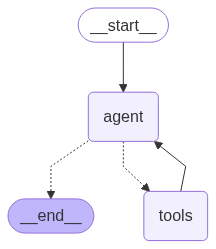

In [17]:
from IPython.display import Image, display

try:
    display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass

#### Run and Evaluate (Estimated Run Time 20min)

**Task:** Execute the ReAct agent pipeline on the dataset and collect SQL outputs.

In [68]:
import re
from langchain_core.messages import HumanMessage
from method_run import run_method

def run_react_agent_with_config_streaming(item):
    question = item['question']
    schema = item['schema']
    user_prompt = f"Question: {question}\nSchema: {schema}"
    input_msg = HumanMessage(content=user_prompt)
    input_config = {"configurable": {"database_name": item['db_id']}, "recursion_limit": 100}

    response_message_ids = set()  # Using a set to track message IDs that have already been printed.
    max_iterations = 75  # Max iterations to prevent infinite recursion
    iteration_count = 0

    # Stream execution of the graph
    for state in react_graph.stream(
        MessagesState(messages=[input_msg]),
        config=input_config,
        stream_mode="values",
        
    ):
        iteration_count += 1
        if iteration_count > max_iterations:
            print("[INFO] Reached maximum iterations.")
            break  # Stop after 25 iterations
        
        # Check the current state in every step
        messages = state.get("messages", [])
        
        if messages:
            for msg in messages:
                if msg.id not in response_message_ids:  # Check if the message ID has already been printed
                    msg.pretty_print()
                    response_message_ids.add(msg.id)  # Track the message ID to prevent future prints
        else:
            print(f"[DEBUG] No messages in this state.")
    
    # Guard: If no messages were returned at all
    if not response_message_ids:
        print("[ERROR] No messages returned from the graph.")
        return {**item, 'sql': "-- ERROR: No response from agent."}

    # Get the last message content (expected to contain SQL)
    last_msg = messages[-1]  # The last message is the final one from the state
    if isinstance(last_msg.content, list):
        last_msg_content = last_msg.content[-1]
    else:
        last_msg_content = last_msg.content
    # Extract SQL
    match = re.search(r'```sql\n(.*?)```', last_msg_content, re.DOTALL)
    if match:
        query = match.group(1).strip()
    else:
        query = re.sub(r'```sql|```', '', last_msg_content.strip())

    return {**item, 'sql': query}

# Run it using the original run_method
run_method(run_react_agent_with_config_streaming, SLEEP_TIME=20, mode="nano")

  0%|          | 0/5 [00:00<?, ?it/s]

================================ Human Message =================================

Question: Find the percentage of atoms with single bond. (Evidence: single bond refers to bond_type = '-'; percentage = DIVIDE(SUM(bond_type = '-'), COUNT(bond_id)) as percentage)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

================================== Ai Message ==================================
Tool Calls:
  get_table_schema (cc6ad9c0-f78f-468b-8b1a-f881410e1309)
 Call ID: cc6ad9c0-f78f-468b-8b1a-f881410e1309
  Args:
    table_name: atom
  get_table_schema (4d2c97d0-9975-499b-a03f-a58b2b9e6fdc)
 Call ID: 4d2c97d0-9975-499b-a03f-a58b2b9e6fdc
  Args:
    table_name: bond
  get_table_schema (dc53558b-152c-4647-952b-75b7d47e3d54)
 Call ID: dc53558b-152c-4647-952b-75b7d47e3d54
  Args:
    table_name: connected
================================= Tool Message =================================
Nam

 20%|██        | 1/5 [01:00<04:00, 60.24s/it]

================================ Human Message =================================

Question: What are the elements for bond id TR001_10_11? (Evidence: element = 'cl' means Chlorine; element = 'c' means Carbon; element = 'h' means Hydrogen; element = 'o' means Oxygen, element = 's' means Sulfur; element = 'n' means Nitrogen, element = 'p' means Phosphorus, element = 'na' means Sodium, element = 'br' means Bromine, element = 'f' means Fluorine; element = 'i' means Iodine; element = 'sn' means Tin; element = 'pb' means Lead; element = 'te' means Tellurium; element = 'ca' means Calcium)
Schema: atom (atom_id, molecule_id, element)
bond (bond_id, molecule_id, bond_type)
connected (atom_id, atom_id2, bond_id)
molecule (molecule_id, label)

================================== Ai Message ==================================
Tool Calls:
  get_table_schema (c3f155a4-db7b-4b4c-b798-b4f3fa41a546)
 Call ID: c3f155a4-db7b-4b4c-b798-b4f3fa41a546
  Args:
    table_name: bond
  get_table_schema (2642d07b-5

 40%|████      | 2/5 [01:58<02:57, 59.14s/it]

================================ Human Message =================================

Question: Which publisher created more superheroes: DC or Marvel Comics? Find the difference in the number of superheroes. (Evidence: DC refers to publisher_name = 'DC Comics'; Marvel Comics refers to publisher_name = 'Marvel Comics'; if SUM(publisher_name = 'DC Comics') > SUM(publisher_name = 'Marvel Comics'), it means DC Comics published more superheroes than Marvel Comics; if SUM(publisher_name = 'Marvel Comics') > SUM(publisher_name = 'Marvel Comics'), it means Marvel Comics published more heroes than DC Comics; difference = SUBTRACT(SUM(publisher_name = 'DC Comics'), SUM(publisher_name = 'Marvel Comics'));)
Schema: alignment (id, alignment)
attribute (id, attribute_name)
colour (id, colour)
gender (id, gender)
publisher (id, publisher_name)
race (id, race)
superhero (id, superhero_name, full_name, gender_id, eye_colour_id, hair_colour_id, skin_colour_id, race_id, publisher_id, alignment_id, height_cm

 60%|██████    | 3/5 [03:07<02:07, 63.79s/it]

================================ Human Message =================================

Question: Find the name and date of events with expenses for pizza that were more than fifty dollars but less than a hundred dollars. (Evidence: name of event refers to event_name; date of event refers to event_date; expenses for pizza refers to expense_description = 'Pizza' where cost > 50 and cost < 100)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

===============

 80%|████████  | 4/5 [04:17<01:06, 66.08s/it]

================================ Human Message =================================

Question: Based on the total cost for all event, what is the percentage of cost for Yearly Kickoff event? (Evidence: DIVIDE(SUM(cost where event_name = 'Yearly Kickoff'), SUM(cost)) * 100)
Schema: event (event_id, event_name, event_date, type, notes, location, status)
major (major_id, major_name, department, college)
zip_code (zip_code, type, city, county, state, short_state)
attendance (link_to_event, link_to_member)
budget (budget_id, category, spent, remaining, amount, event_status, link_to_event)
expense (expense_id, expense_description, expense_date, cost, approved, link_to_member, link_to_budget)
income (income_id, date_received, amount, source, notes, link_to_member)
member (member_id, first_name, last_name, email, position, t_shirt_size, phone, zip, link_to_major)

================================== Ai Message ==================================
Tool Calls:
  get_table_schema (cc68984d-3599-46ad-b4

100%|██████████| 5/5 [05:27<00:00, 65.53s/it]


Starting to compare without knowledge for ex
Process finished successfully
start calculate
                     simple               moderate             challenging          total               
count                1                    1                    3                    5                   
======================================    ACCURACY    =====================================
accuracy             0.00                 0.00                 33.33                20.00               
Finished evaluation

